# Algoritmo genético para el problema TSP

In [1]:
import numpy as np
from scipy.spatial import distance
import networkx as nx
import matplotlib.pyplot as plt

Se generan puntos aleatorios en un espacio bidimensional

In [2]:
n_points = 20

In [3]:
pos = { i:(np.random.random(),np.random.random()) for i in range(n_points)}

Se crea un grafo a partir de esos puntos

In [4]:
G = nx.Graph()

In [5]:
for i in range(n_points):
  G.add_node(i)

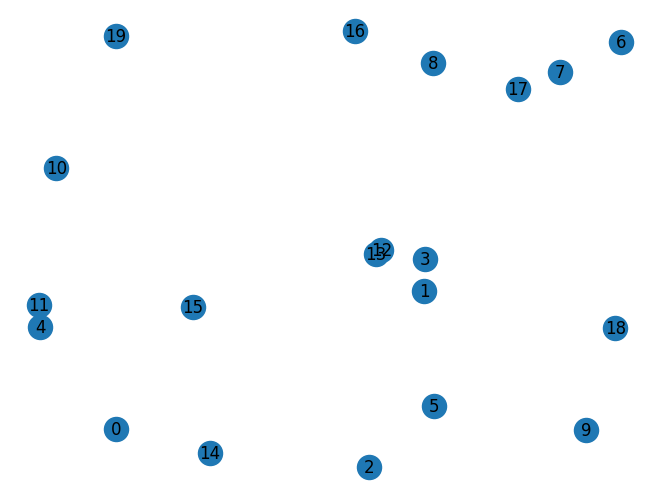

In [6]:
nx.draw(G,pos, with_labels=True)

Se utilizará la distancia euclidiana como métrica para el problema TSP

In [7]:
distance.euclidean(pos[0],pos[1])

0.544568803540485

## Algoritmo genético

### Población aleatoria

Se genera una población con genes aleatorios

In [8]:
n_population = 1000

In [9]:
possible_gen = list(pos.keys())

In [10]:
intial_population = [np.random.choice(possible_gen,n_points,False) for i in range(n_population) ]

Ejemplo de individuo

In [11]:
intial_population[0]

array([ 2, 18, 17,  0, 12,  9, 10, 15,  6, 14, 13,  8, 16,  7,  3,  5, 11,
       19,  4,  1])

###Fitness

Función para obtener la distancia total del camino marcado por los genes

In [12]:
def get_total_distance(order, pos):
  order = list(order)
  ring_path = order.copy()
  ring_path.append(order[0])
  total_distance = 0
  for i in range(n_points):
    pos1 = pos[ring_path[i]]
    pos2 = pos[ring_path[i+1]]
    total_distance += distance.euclidean(pos1,pos2)
  return total_distance

In [13]:
get_total_distance(intial_population[0],pos)

11.12039516600002

In [14]:
get_total_distance(range(n_points),pos)

10.337444902185732

Se obtiene la distancia total de todos los individuos

In [15]:
fitness = [get_total_distance(parent,pos) for parent in intial_population]

In [16]:
fitness[:5]

[11.12039516600002,
 9.553207869204305,
 10.724141763537991,
 10.676945500564896,
 11.066517301059685]

In [17]:
fitness = np.array(fitness)

Las distancias más cortas deben tener una mayor probabilidad de reproducrise

In [18]:
fitness = fitness.max() - fitness + 1 # to avoid 0

In [19]:
fitness.min()

1.0

In [20]:
fitness[:5]

array([3.68245417, 5.24964147, 4.07870757, 4.12590384, 3.73633204])

In [21]:
fitness = fitness/fitness.sum()

In [22]:
fitness[:5]

array([0.00103491, 0.00147535, 0.00114627, 0.00115953, 0.00105005])

In [23]:
fitness.sum()

1.0

In [24]:
fitness.max()

0.0018812185652779944

### Mutación

Se crea una función para cambiar de orden dos genes en un individuo. El `mutation_rate` siempre debe ser bajo.

In [25]:
def mutation(order):
  mutation_rate = 0.001
  for i in range(n_points):
    if(np.random.random()<mutation_rate):
      mutation = np.random.randint(n_points)
      # change order of two genes
      temp = order[mutation]
      order[mutation] = order[i]
      order[i] = temp
  return order

In [26]:
mutation(list(range(n_points)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Reproducción

Función para combinar genes de dos padres. En caso de que el gen de un padre ya exista en el individuo, se cambia de lugar. Esto puede interpretarse como una mutación, ya que el ADN final puede contener secciones que no pertenecen a ningún padre. La exactitud con la que se logra representar el entrecruzamiento depende del resultado que se quiera lograr.

In [27]:
def combine_genes(parent1,parent2):
  parent1 = list(parent1)
  parent2 = list(parent2)
  new_order = parent1.copy()
  for i in range(n_points):
    if(np.random.random() < 0.5): #flip a coin
      idx = new_order.index(parent2[i])
      new_order[idx] = new_order[i]
      new_order[i] = parent2[i]


  return new_order


In [28]:
combine_genes(range(n_points),range(n_points-1,-1,-1))

[19, 18, 2, 16, 15, 5, 13, 7, 11, 10, 9, 8, 12, 6, 14, 4, 3, 17, 1, 0]

Evolution

Número de generaciones

In [29]:
epochs = 1000

In [30]:
current_population = intial_population

Listas para documentar la evolución

In [31]:
min_path_distance = []
min_distance = []
mean_distance = []

* Se crea una nueva generación a partir de dos individuos con mejores genes.
* Se reserva un puesto para el mejor individuo de la generación anterior, esto permitirá tener la permanencia del mejor resultados.
* Se calcula el nuevo fintess y se repite

0 8.109018800269205


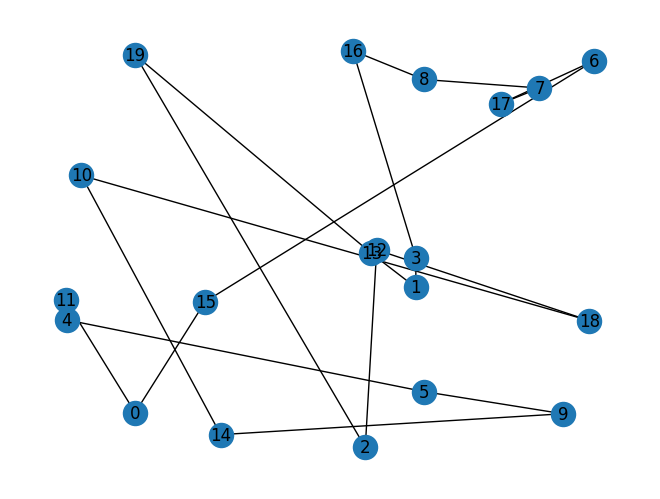

100 6.994531882904621


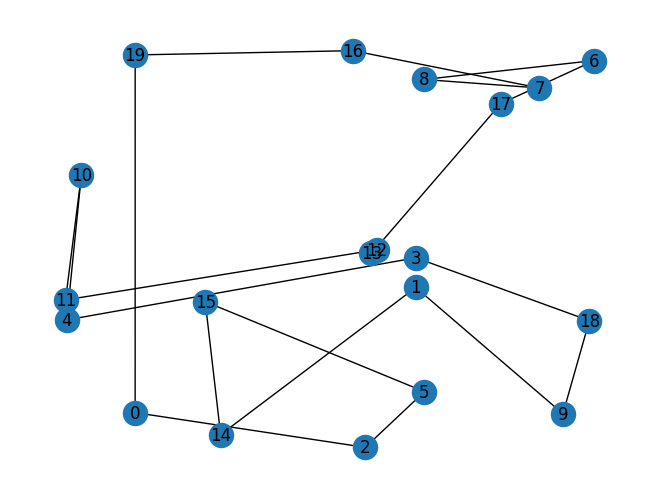

200 6.87606985052593


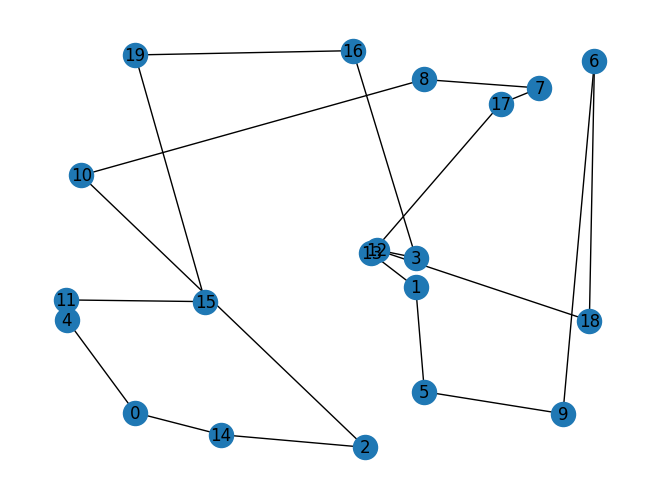

300 6.660826844572071


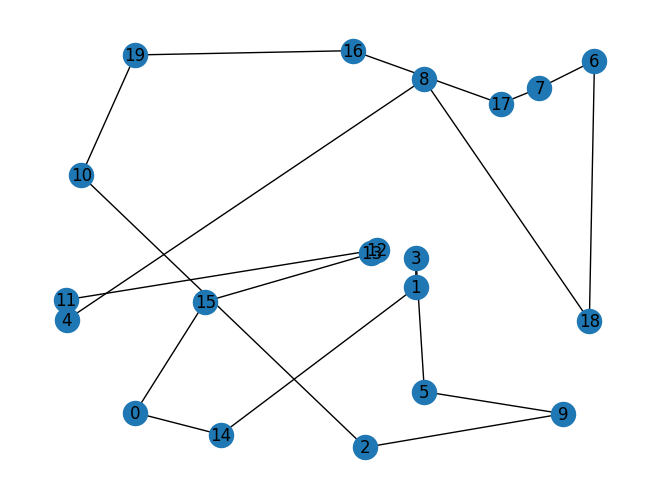

400 6.3360394535376265


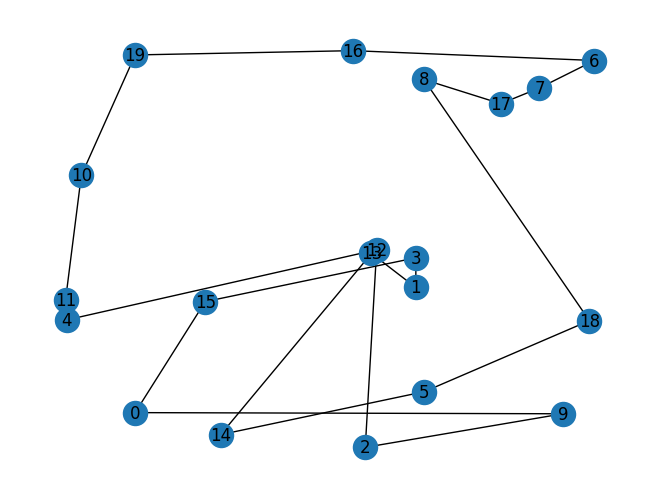

500 6.3360394535376265
600 6.181409233494625


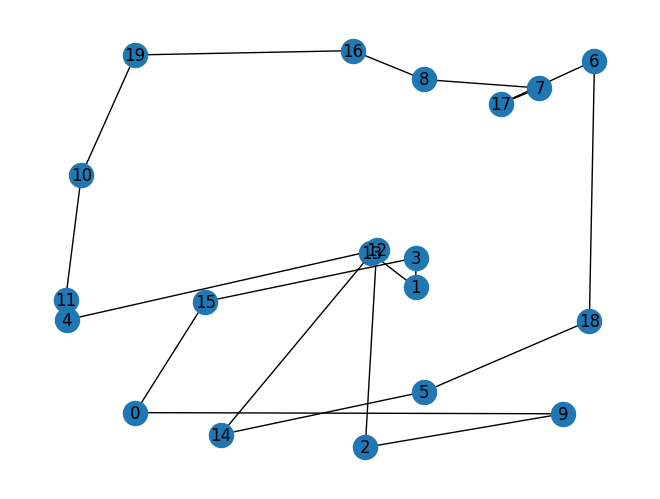

700 6.169477381599108


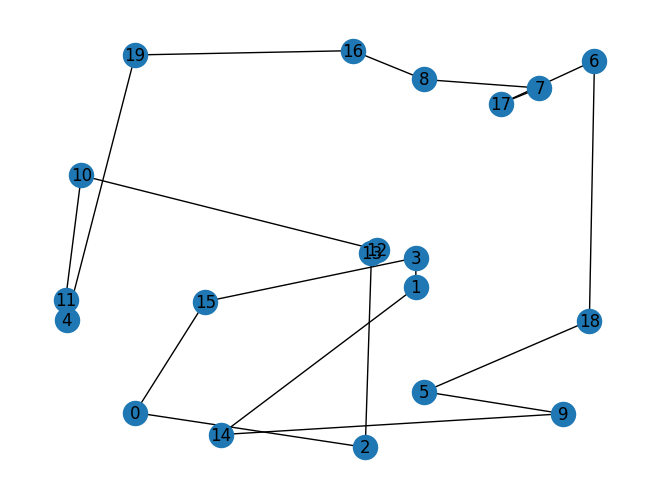

800 5.768643394502064


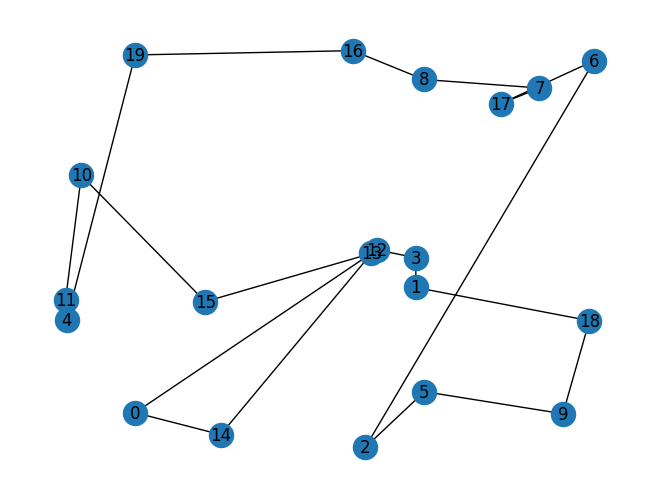

900 5.768268747062603


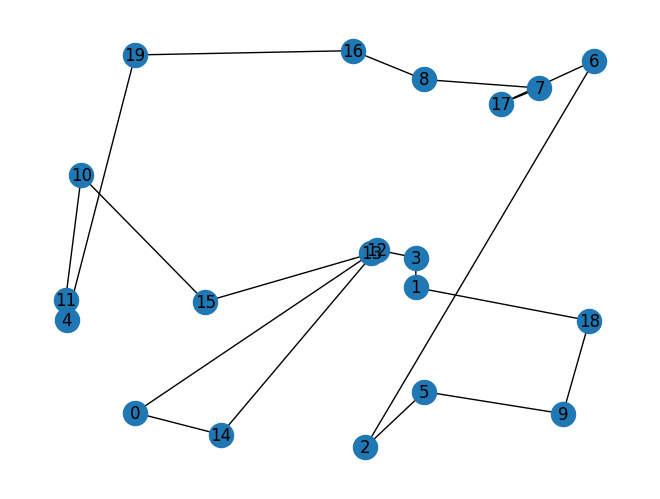

In [32]:
for t in range(epochs):
  new_generation = []
  for _ in range(n_population-1):
    #select two parents
    parents = np.random.choice(n_population,p=fitness,size=2,replace=False)
    parent1 = current_population[parents[0]]
    parent2 = current_population[parents[1]]
    new_path = combine_genes(parent1,parent2)
    new_path = mutation(new_path)
    new_generation.append(new_path)
  idx = np.where(fitness == fitness.max())[0][0]
  # el mejor individuo de la generación anterior prevalece
  new_generation.append(current_population[idx])
  current_population = new_generation
  # nuevo fitness
  fitness = [get_total_distance(parent,pos) for parent in current_population]
  min_distance.append(min(fitness))
  mean_distance.append(np.mean(fitness))
  fitness = np.array(fitness)
  fitness = fitness.max() - fitness + 1
  fitness = fitness/fitness.sum()

  # get best path each 100 epochs
  if(t % 100 == 0):
    min_idx = np.where(fitness == fitness.max())[0][0]
    d = get_total_distance(current_population[min_idx],pos)
    print(t,d)
    if(d not in min_path_distance):
      min_path_distance.append(d)

      draw_edges = current_population[min_idx].copy()
      draw_edges = list(draw_edges)
      draw_edges.append(draw_edges[0])

      G = nx.Graph()
      for i in range(n_points):
        G.add_node(i)

      for i in range(len(draw_edges)-1):
        G.add_edge(draw_edges[i],draw_edges[i+1])

      nx.draw(G,pos, with_labels=True)
      plt.show()

Se puede observar cómo progresa el algoritmo en encontrar la distancia mínima para el problema. Llega a estancarse en cierto punto, pero todavía hay posibilidad de mejora con unas cuantes épocas. Hay que tomar en consideración el número de puntos.

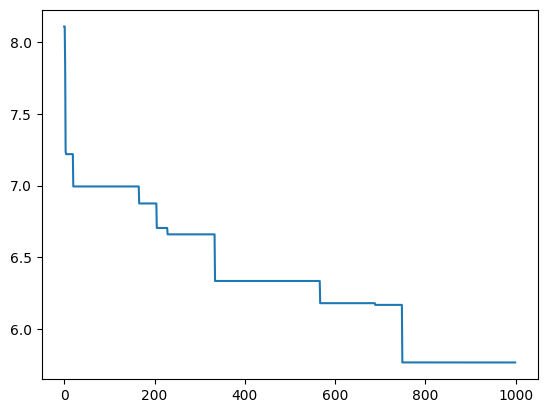

In [33]:
plt.plot(min_distance)

La distancia promedio de cada generación muestra que no hay una tendencia a la baja. Esto se debe a que cambiar el orden de dos puntos puede alterar la distancia del camino total en gran medida. Dos padres con buenos genes no necesarimente van a generar un camino mejor. Por eso es importante que el mejor individuo prevalezca a lo largo del tiempo.

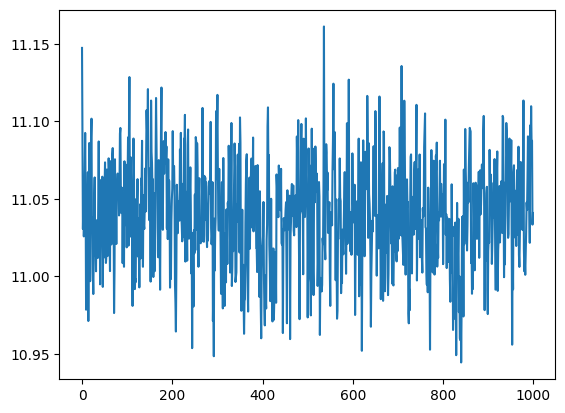

In [34]:
plt.plot(mean_distance)

In [35]:
all_distances = [get_total_distance(parent,pos) for parent in current_population]

Se observa que la mayoría de los individuos tienen una distancia total lejana al mínimo. Parece que los datos siguen una distribución normal.

(array([  1.,   0.,   1.,   9.,  48., 148., 307., 286., 167.,  33.]),
 array([ 5.76826875,  6.52859071,  7.28891267,  8.04923464,  8.8095566 ,
         9.56987856, 10.33020052, 11.09052249, 11.85084445, 12.61116641,
        13.37148838]),
 <BarContainer object of 10 artists>)

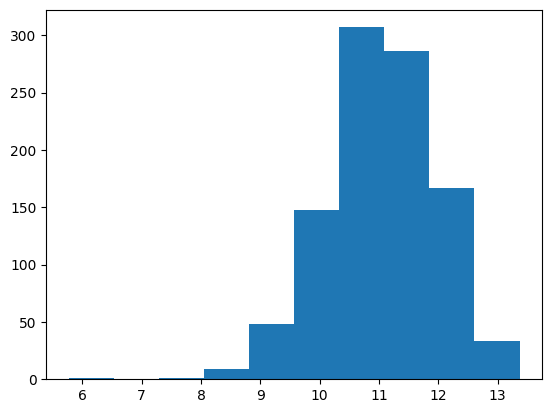

In [36]:
plt.hist(all_distances)

Se grafica al mejor individuo de la evolución con la distancia más corta.

In [37]:
min_idx = np.where(fitness == fitness.max())[0][0]

In [38]:
draw_edges = current_population[min_idx].copy()

In [39]:
draw_edges.append(draw_edges[0])

In [40]:
G = nx.Graph()
for i in range(n_points):
  G.add_node(i)

In [41]:
for i in range(len(draw_edges)-1):
  G.add_edge(draw_edges[i],draw_edges[i+1])

In [42]:
current_population[min_idx]

[14, 0, 13, 15, 10, 11, 4, 19, 16, 8, 7, 17, 6, 2, 5, 9, 18, 1, 3, 12]

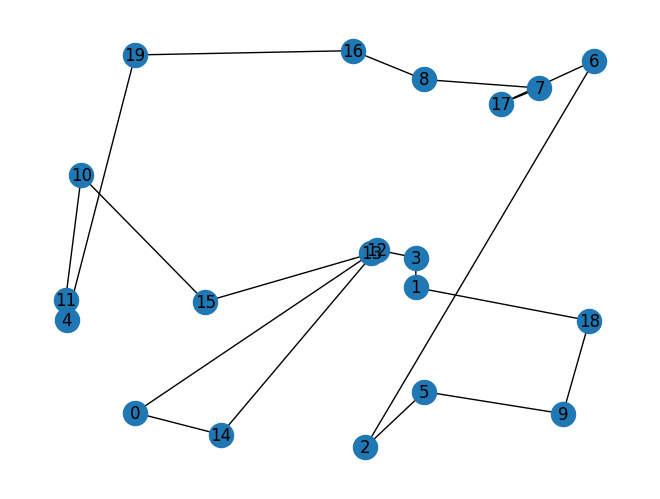

In [43]:
nx.draw(G,pos, with_labels=True)

In [44]:
get_total_distance(current_population[min_idx],pos)

5.768268747062603

Se guardan los datos para aplicar otro algoritmo sobre el problema y ver si se pueden obtener mejores resultados.

In [45]:
pos

{0: (0.19257330736027733, 0.12161059271247321),
 1: (0.6522950511028276, 0.4135199966716884),
 2: (0.5695754813419752, 0.04061269747585372),
 3: (0.6525608870367675, 0.4827813052498767),
 4: (0.08057769200452691, 0.3378568229070328),
 5: (0.6664627450525165, 0.17050739158982564),
 6: (0.9450617108347991, 0.9429213968602855),
 7: (0.8548192854291998, 0.8788118806064951),
 8: (0.6655148367477006, 0.8986695561767248),
 9: (0.8933656954402229, 0.11892800856194774),
 10: (0.10438035356581443, 0.6749327293714703),
 11: (0.07853454066200116, 0.3845193150840983),
 12: (0.5882337456834411, 0.5014220790723367),
 13: (0.579768788352602, 0.49292939006002123),
 14: (0.33263136856202913, 0.0702588235471805),
 15: (0.3073964173320006, 0.3805045032448894),
 16: (0.5492961145645515, 0.9659159962020433),
 17: (0.791529143269832, 0.8421835595699904),
 18: (0.936713923924484, 0.3361353994287505),
 19: (0.1926305685361216, 0.9558862025879181)}

In [46]:
import json

In [47]:
TSP = json.dumps(pos)

In [48]:
with open("./mapa_TSP.txt","a") as file:
  resultado = json.dumps(TSP)
  file.write(resultado)
  file.write('\n')